### 建模

### 加载工具包与上次保存的数据

In [25]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 160)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import KFold, StratifiedKFold

import optuna

# FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
#                   'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
#                   'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
#                   'OOF_PRED', 'month_0']

FEATS_EXCLUDED = ['first_active_month', 'target', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size']

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",
                                                                                                   ascending=False)[
           :40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

In [2]:
# 加载上次保存数据
train_features = pd.read_csv('data/output/3/last_train_df.csv')
test_features = pd.read_csv('data/output/3/last_test_df.csv')

print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)

Training Feature Size:  (201917, 217)
Testing Feature Size:   (123623, 217)


In [34]:
#测试集target没有值，所以这里用训练集来划分出来训练集和测试来测试不同回归模型的效果。
X = train_features.drop(columns = FEATS_EXCLUDED)
y =  pd.DataFrame(train_features["target"])

# Replace the inf and -inf with nan (required for later imputation)
X = X.replace({np.inf: np.nan, -np.inf: np.nan})

# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X)

# Transform both training data and testing data
X = imputer.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X1 = test_features.drop(columns = FEATS_EXCLUDED1)

# Replace the inf and -inf with nan (required for later imputation)
X1 = X1.replace({np.inf: np.nan, -np.inf: np.nan})

imputer.fit(X1)

X1 = imputer.transform(X1)

In [ ]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing  features:  ', np.sum(np.isnan(X_test)))
print('Missing values in testing1 features: ', np.sum(np.isnan(X1)))

In [24]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))
print(np.where(~np.isfinite(X1)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [29]:
# Convert y to one-dimensional array (vector)
y_train = np.array(y_train).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

### 建立一个Baseline

在建模之前，我们得有一个最坏的打算，就是模型起码得有点作用才行。

In [7]:
# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_rmse = rmse(y_test, model_pred)
    
    # Return the performance metric
    return model_rmse

如果用中位数来猜的话，结果是多少。

### 选择机器学习算法（回归问题）

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression
6. LightBGM

In [8]:
lr = LinearRegression()
lr_rmse = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: RMSE = %0.4f' % lr_rmse)

Linear Regression Performance on the test set: RMSE = 3.7524


In [9]:
# svm = SVR(C = 1000, gamma = 0.1)
# svm_rmae = fit_and_evaluate(svm)

# print('Support Vector Machine Regression Performance on the test set: RMAE = %0.4f' % svm_rmae)

In [10]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_rmse = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: RMSE = %0.4f' % random_forest_rmse)

Random Forest Regression Performance on the test set: RMSE = 3.9692


In [11]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_rmse = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: RMSE = %0.4f' % gradient_boosted_rmse)

Gradient Boosted Regression Performance on the test set: RMSE = 3.7140


In [12]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_rmse = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: RMSE = %0.4f' % knn_rmse)

K-Nearest Neighbors Regression Performance on the test set: RMSE = 3.9640


In [42]:
def lightBGM_default():
    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train,label=y_train ,free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test ,label=y_test, reference=lgb_train)
    
    # specify your configurations as a dict
    params = {
        'objective': 'regression'
    }

    print('Starting training...')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=20,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=5)

    print('Starting predicting...')
    # predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    lightBGM_rmse = rmse(y_test, y_pred)
    # eval
    print('The rmse of prediction is:3.705614')
    return lightBGM_rmse

lightBGM_rmse = lightBGM_default()

Starting training...
[1]	valid_0's l2: 14.8032
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 14.6431
[3]	valid_0's l2: 14.509
[4]	valid_0's l2: 14.39
[5]	valid_0's l2: 14.2951
[6]	valid_0's l2: 14.2202
[7]	valid_0's l2: 14.168
[8]	valid_0's l2: 14.101
[9]	valid_0's l2: 14.0588
[10]	valid_0's l2: 14.0208
[11]	valid_0's l2: 13.9815
[12]	valid_0's l2: 13.9462
[13]	valid_0's l2: 13.912
[14]	valid_0's l2: 13.8968
[15]	valid_0's l2: 13.8794
[16]	valid_0's l2: 13.8596
[17]	valid_0's l2: 13.8383
[18]	valid_0's l2: 13.8239
[19]	valid_0's l2: 13.8142
[20]	valid_0's l2: 13.8058
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 13.8058
Starting predicting...
The rmse of prediction is:3.705614


In [40]:
lightBGM_rmse = 3.710019572972698

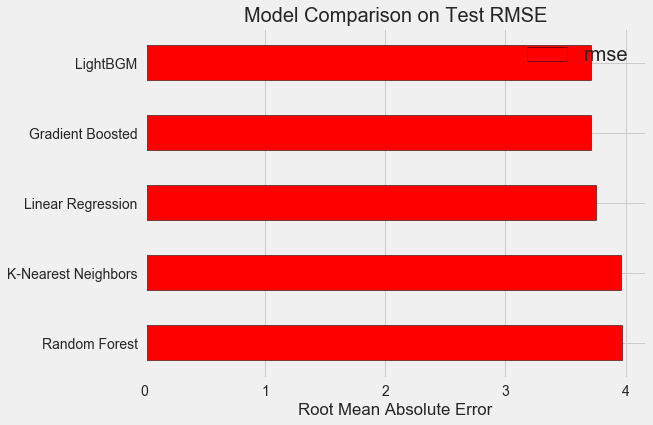

In [41]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
# model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
#                                            'Random Forest', 'Gradient Boosted',
#                                             'K-Nearest Neighbors','LightBGM'],
#                                  'rmae': [lr_rmae, svm_rmae, random_forest_rmae, 
#                                          gradient_boosted_rmae, knn_rmae, lightBGM_rmae ]})

model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors','LightBGM'],
                                 'rmse': [lr_rmse, random_forest_rmse, 
                                         gradient_boosted_rmse, knn_rmse, lightBGM_rmse ]})

# Horizontal bar chart of test rmae
model_comparison.sort_values('rmse', ascending = False).plot(x = 'model', y = 'rmse', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); 
plt.yticks(size = 14); 
plt.xlabel('Root Mean Absolute Error'); 
plt.xticks(size = 14)
plt.title('Model Comparison on Test RMSE', size = 20);

目前在默认情况下，随机森铃效果，虽然缺乏公平性，随机森林主要有3类参数可调，max_features，n_estimators，min_sample_leaf。

array([ 1.42360616, -2.72480262, -0.79645093, ..., -0.77847645,
       -2.23770548,  1.22843632])

In [35]:
# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate_last(model):
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X1)
    
    # Return the performance metric
    return model_pred

# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

# Create the model to use for hyperparameter tuning
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

# Fit on the training data
random_cv.fit(X, y)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


/Users/leichen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/leichen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/leichen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/leichen/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please 

KeyboardInterrupt: 

In [ ]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False ,params_default = False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # 交叉验证方式
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

    #训练集预测结果存放变量
    oof_preds = np.zeros(train_df.shape[0])
    #测试集预测结果存放变量
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        if params_default :
            params = {
                'boosting_type': 'gbdt',
                'objective': 'regression'
            }
        else:    
            params = {
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed': int(2 ** n_fold),
                'bagging_seed': int(2 ** n_fold),
                'drop_seed': int(2 ** n_fold)
            }

        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=['train', 'test'],
            num_boost_round=10000,
            early_stopping_rounds=200,
            verbose_eval=100
        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(
            reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # 显示特征重要性
    display_importances(feature_importance_df)

    if not debug:
        # 保存submission
        test_df.loc[:, 'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [ ]:
# with timer("Run LightGBM with kfold"):
kfold_lightgbm(train_features, test_features, num_folds=11, stratified=False)

### 特征重要性